In [1]:
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
# from sklearn.preprocessing import Imputer, MinMaxScaler  # Imputer deprecated in 0.20 version of sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer                   # Use SimpleImputer instead

# Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# Set the Year for the data to use
YEAR = 2017

# Read data into dataframes
train_features = pd.read_csv('data/' + str(YEAR) + '/training_features_' + str(YEAR) + '.csv')
test_features = pd.read_csv('data/' + str(YEAR) + '/testing_features_' + str(YEAR) + '.csv')
train_labels = pd.read_csv('data/' + str(YEAR) + '/training_labels_' + str(YEAR) + '.csv')
test_labels = pd.read_csv('data/' + str(YEAR) + '/testing_labels_' + str(YEAR) + '.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size: ', test_features.shape)
print('Training Labels Size: ', train_labels.shape)
print('Testing Labels Size: ', test_labels.shape)

Training Feature Size:  (6622, 62)
Testing Feature Size:  (2839, 62)
Training Labels Size:  (6622, 1)
Testing Labels Size:  (2839, 1)


In [3]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Bronx,Borough_Brooklyn,Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,Largest Property Use Type_Mailing Center/Post Office,Largest Property Use Type_Manufacturing/Industrial Plant,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13277,4405684,75378.0,1939,1,100,71.6,3.6,0.0,28.01,5.944373,3.332562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7398,4398430,73500.0,1929,1,100,134.4,10.6,0.1,81.47,6.234215,4.400235,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9487,3072455,53784.0,1931,1,100,71.3,3.5,0.0,80.12,5.457882,4.383526,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,6.510853,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3297,2704322,253749.0,1930,1,100,65.6,3.9,0.0,38.20,2.928524,3.642836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1065,4862786,54431.0,1911,1,100,54.7,4.6,0.4,22.43,4.764735,3.110399,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10856,3114783,78718.0,1930,1,100,80.9,4.6,0.7,94.29,5.715052,4.546375,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4295,2667275,184500.0,1960,1,100,85.9,7.6,0.0,NaN,2.610070,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12975,4408019,103226.0,1951,1,100,87.1,4.8,0.7,NaN,6.050676,NaN,0,0,0,0,0,0,0,0,0,0,

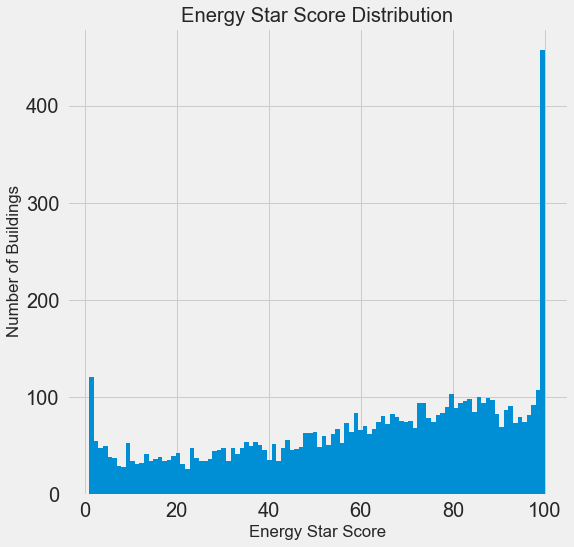

In [4]:
figsize(8, 8)

# Plot histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Energy Star Score');
plt.ylabel('Number of Buildings');
plt.title('Energy Star Score Distribution');

In [5]:
# Create an imputer object with a median filling strategy
# imputer = Imputer(strategy = 'median')      # Imputer deprecated in 0.20 version of sklearn
imputer = SimpleImputer(strategy = 'median')      # Use SimpleImputer instead

# Train the imputer object on the training features
imputer.fit(train_features)

# Transform both the training data and the testing data (to fill in missing values)
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Users\ahenders\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features: ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:  0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and the testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

# Models to Evaluate

We will compare five different machine learning models using scikit-learn:

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression


In [10]:
# Function to calculate the MAE (Mean Absolute Error) score for each model
def mae (y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    # Train the model
    model.fit(X, y)
    
    # Make prediction and evaluate
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Peformance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Peformance on the test set: MAE = 13.6391


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Peformance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Peformance on the test set: MAE = 10.9899


In [13]:
rf = RandomForestRegressor(random_state = 60)
rf_mae = fit_and_evaluate(rf)

print('Random Forest Regression Peformance on the test set: MAE = %0.4f' % rf_mae)

C:\Users\ahenders\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Peformance on the test set: MAE = 9.8477


In [14]:
gb = GradientBoostingRegressor(random_state = 60)
gb_mae = fit_and_evaluate(gb)

print('Gradient Boosting Regression Peformance on the test set: MAE = %0.4f' % gb_mae)

Gradient Boosting Regression Peformance on the test set: MAE = 9.8399


In [15]:
knn = KNeighborsRegressor(n_neighbors = 10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Peformance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Peformance on the test set: MAE = 12.0977


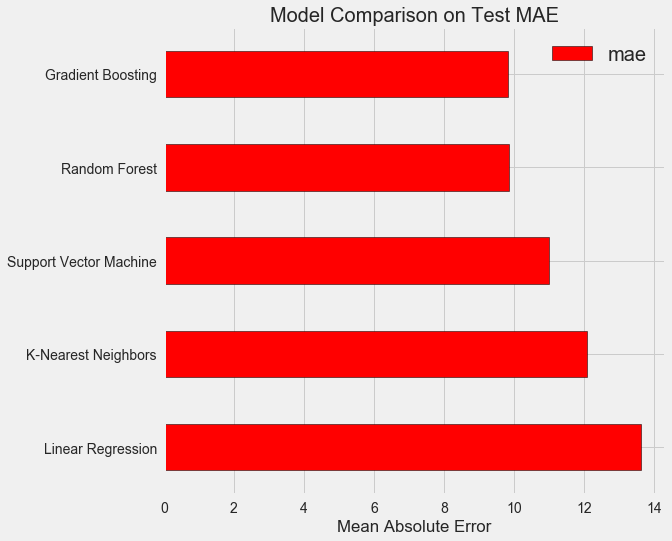

In [16]:
plt.style.use('fivethirtyeight')
figsize(8, 8)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                          'Random Forest', 'Gradient Boosting',
                                          'K-Nearest Neighbors'],
                                'mae': [lr_mae, svm_mae, rf_mae, gb_mae, knn_mae]})

# Horizontal bar chart of test mae values
model_comparison.sort_values('mae', ascending=False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                         color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel('');
plt.yticks(size = 14);
plt.xlabel('Mean Absolute Error');
plt.xticks(size = 14);
plt.title('Model Comparison on Test MAE', size = 20);

In [17]:
# Define the loss functions
loss = ['ls', 'lad', 'huber']

# Define the numbers of tress used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Define the maximum depths of each tree
max_depth = [2, 3, 5, 10, 15]

# Define the minimum number of samples to split a leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Define the maximum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Define the maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                      'n_estimators': n_estimators,
                      'max_depth': max_depth,
                      'min_samples_leaf': min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}


In [18]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator = model,
                              param_distributions = hyperparameter_grid,
                              cv = 4,
                              n_iter = 25,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs = 1,
                              verbose = 1,
                              return_train_score = True,
                              random_state = 42)

In [19]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 19.8min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [20]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,5.119016,0.015232,-8.984508,-6.988425,lad,5,None,6,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",1,-9.115280,-6.961005,-8.990045,-7.176300,-8.860352,-7.036716,-8.972272,-6.779680,0.106083,0.000824,0.090411,0.143139
3,6.361089,0.016991,-9.053745,-4.510647,huber,5,None,8,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",2,-9.165608,-4.560360,-9.058336,-4.331602,-8.939933,-4.651687,-9.051031,-4.498940,0.213160,0.000017,0.079835,0.116788
9,3.666260,0.010756,-9.091451,-7.095075,huber,3,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",3,-9.245572,-6.975570,-9.030133,-7.154433,-9.001150,-7.177282,-9.088892,-7.073013,0.101763,0.000844,0.094446,0.079135
0,1.082993,0.005000,-9.164206,-7.434636,ls,5,auto,6,2,100,"{'n_estimators': 100, 'min_samples_split': 2, ...",4,-9.328500,-7.477974,-9.207620,-7.356142,-8.926684,-7.377526,-9.193896,-7.526904,0.066919,0.000708,0.146771,0.070382
7,2.666269,0.010490,-9.264169,-7.159207,ls,3,auto,6,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",5,-9.388473,-7.125037,-9.270686,-7.143300,-9.146632,-7.162551,-9.250808,-7.205940,0.124412,0.000510,0.085860,0.030066
10,32.384262,0.083272,-9.353231,-0.427060,huber,10,None,6,10,1100,"{'n_estimators': 1100, 'min_samples_split': 10...",6,-9.428609,-0.392344,-9.395825,-0.429195,-9.193861,-0.432028,-9.394558,-0.454672,0.752176,0.001481,0.093001,0.022343
2,34.376268,0.069241,-9.393896,-0.196257,huber,10,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",7,-9.438162,-0.193105,-9.533328,-0.207781,-9.249681,-0.226477,-9.354302,-0.157665,7.638102,0.030093,0.104602,0.025226
16,7.941001,0.030014,-9.403536,-5.054263,ls,3,None,6,4,1500,"{'n_estimators': 1500, 'min_samples_split': 4,...",8,-9.464218,-5.052768,-9.406320,-5.013440,-9.223967,-5.008505,-9.519601,-5.142340,0.006441,0.000707,0.111123,0.053666
21,2.623251,0.018008,-9.508369,-6.511642,huber,5,log2,4,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",9,-9.622005,-6.470650,-9.567353,-6.508238,-9.428539,-6.552119,-9.415474,-6.515560,0.270451,0.000992,0.088593,0.028921
13,5.165262,0.042267,-9.509269,-6.559530,lad,5,sqrt,1,10,1500,"{'n_estimators': 1500, 'min_samples_split': 10...",10,-9.668424,-6.490116,-9.510060,-6.573482,-9.327986,-6.599360,-9.530511,-6.575160,0.023803,0.000421,0.121082,0.041364


In [21]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad',
                                  max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model,
                           param_grid=trees_grid,
                           cv = 4, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 1,
                           n_jobs = 1,
                           return_train_score = True)

In [23]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.0min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samp...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

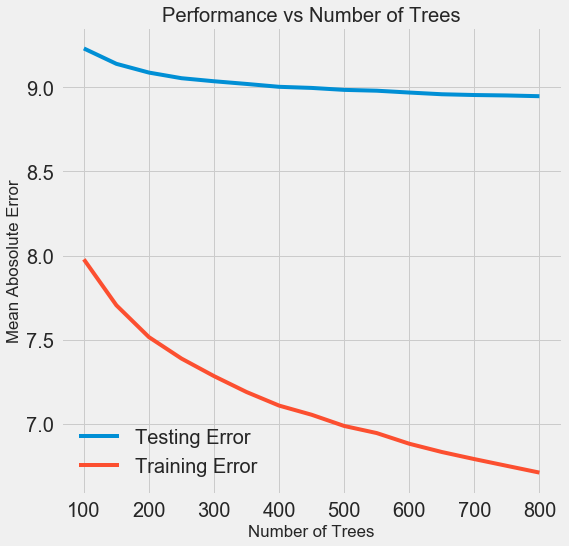

In [24]:

# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees');
plt.ylabel('Mean Abosolute Error');
plt.legend();
plt.title('Performance vs Number of Trees');

In [25]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
14,9.364799,0.022735,-8.946942,-6.711505,800,{'n_estimators': 800},1,-9.110630,-6.718732,-8.944034,-6.945922,-8.804342,-6.710577,-8.928664,-6.470791,0.932099,0.000839,0.108941,0.168038
13,8.052631,0.022758,-8.951355,-6.751517,750,{'n_estimators': 750},2,-9.103757,-6.741527,-8.954797,-6.985577,-8.810734,-6.753483,-8.936040,-6.525482,0.290717,0.000823,0.103981,0.162773
12,7.846675,0.021239,-8.953948,-6.791705,700,{'n_estimators': 700},3,-9.106465,-6.776529,-8.954177,-7.027255,-8.814972,-6.790971,-8.940087,-6.572066,0.731874,0.001072,0.103404,0.161211
11,8.097467,0.021750,-8.958544,-6.833829,650,{'n_estimators': 650},4,-9.109820,-6.824222,-8.959356,-7.045609,-8.814188,-6.850231,-8.950721,-6.615254,1.552634,0.002037,0.104625,0.152469
10,6.162267,0.018247,-8.968677,-6.882922,600,{'n_estimators': 600},5,-9.110045,-6.859964,-8.966307,-7.083881,-8.839829,-6.936535,-8.958441,-6.651308,0.090323,0.000842,0.095784,0.156070


In [26]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

784 ms ± 61.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

10.9 s ± 1.4 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 9.8380.
Final model performance on the test set:   MAE = 8.9161.


C:\Users\ahenders\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


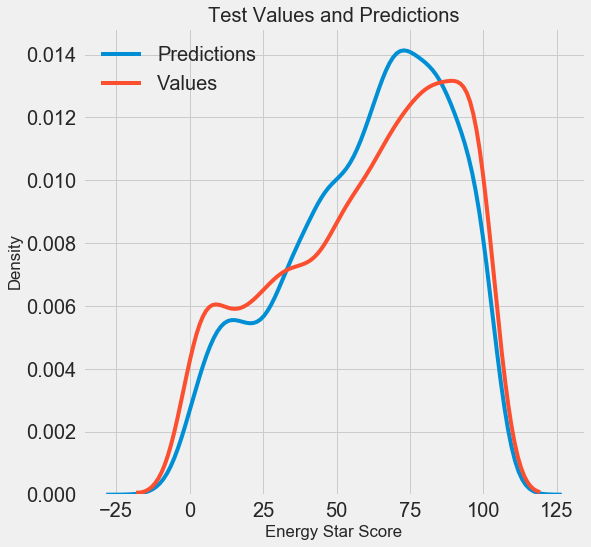

In [30]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score');
plt.ylabel('Density');
plt.title('Test Values and Predictions');

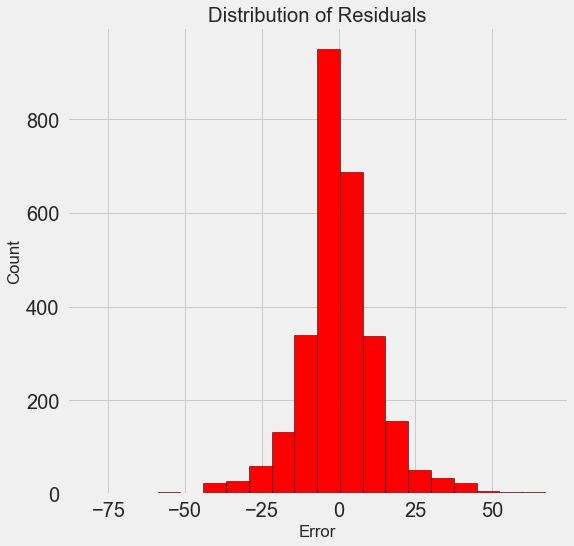

In [31]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals,
         color = 'red',
         bins = 20,
         edgecolor = 'black')
plt.xlabel('Error');
plt.ylabel('Count')
plt.title('Distribution of Residuals');

In [33]:
from joblib import dump


In [34]:
dump(final_model, 'final_model.joblib')


['final_model.joblib']